In [1]:
import ironman
import numpy as np
import pandas as pd
import corner
import matplotlib.pyplot as plt
import rmfit
from astropy import units as u
from astropy import constants as c
import juliet
from astropy.timeseries import LombScargle

In [2]:
#from matplotlib import rc
#rc('font', **{'family':'sans-serif'}) Use only if you have pdflatex (recommended)
#rc('text', usetex=True)

plt.rcParams['xtick.top'] =  True
plt.rcParams['xtick.direction'] =  'in'
plt.rcParams['xtick.major.width'] =  1.0
plt.rcParams['xtick.minor.width'] =  1.0
plt.rcParams['ytick.right'] =  True
plt.rcParams['ytick.direction'] =  'in'
plt.rcParams['ytick.major.width'] = 1.0
plt.rcParams['ytick.minor.width'] =  1.0
plt.rcParams['lines.markeredgewidth'] =  1.0

In [3]:
dataset = juliet.load(input_folder = 'TOI-2431_juliet_GP_new', out_folder = 'TOI-2431_juliet_GP_new')
results = dataset.fit(sampler = "dynamic_dynesty")

Detected dynamic_dynesty sampler output files --- extracting from TOI-2431_juliet_GP_new/_dynesty_DNS_posteriors.pkl


In [4]:
#results.nested_sampling.results.logz[-1]

In [5]:
P = juliet.utils.get_quantiles(results.posteriors['posterior_samples']['P_p1'])[0]
t0 = juliet.utils.get_quantiles(results.posteriors['posterior_samples']['t0_p1'])[0]
print(P,t0)

0.22419577723520057 2460258.868562183


# Photometry

In [6]:
def plot_with_gp(instrument, title, name, P, t0):
    global results
    x = dataset.times_lc[instrument]
    phases = juliet.utils.get_phases(dataset.times_lc[instrument], P, t0)
    transit_plus_GP = results.lc.evaluate(instrument)
    transit_model = results.lc.model[instrument]['deterministic']
    gp_model = results.lc.model[instrument]['GP']

    jitter = np.median(results.posteriors['posterior_samples']['sigma_w_'+instrument]) / 1e6
    
    mask = np.logical_or(np.logical_and(phases>-0.05,phases<-0.02),np.logical_and(phases<0.05,phases>0.02))
    #print(mask)
    oot = (dataset.data_lc[instrument] - gp_model)[mask]
    m_inst = 1-np.mean(oot)
    
    # print(x)
    # print(phases)
    # print(transit_plus_GP)
    # print(transit_model)
    # print(gp_model)
    # print(jitter)
    
    #m_inst = juliet.utils.get_quantiles(results.posteriors['posterior_samples']['mflux_'+instrument])[0]
    transit_model = results.lc.model[instrument]['deterministic']
    
    fig, ax = plt.subplots(dpi=100)
    plt.errorbar(phases,dataset.data_lc[instrument]-gp_model+m_inst,yerr = np.sqrt(dataset.errors_lc[instrument]**2.0 + jitter**2.0), fmt = '.', alpha = 0.7)

    idx = np.argsort(phases)
    plt.plot(phases[idx],transit_model[idx], color='black',zorder=10)

    plt.xlim([-0.5,0.5])
    #plt.ylim([0.98,1.02])
    plt.title(title)
    #plt.xlim()
    #plt.ylim([0.995,1.005])
    plt.xlabel('Phase')
    plt.ylabel('Relative flux')
    plt.show()

    return phases, dataset.data_lc[instrument], np.sqrt(dataset.errors_lc[instrument]**2.0 + jitter**2.0), transit_model, m_inst, gp_model

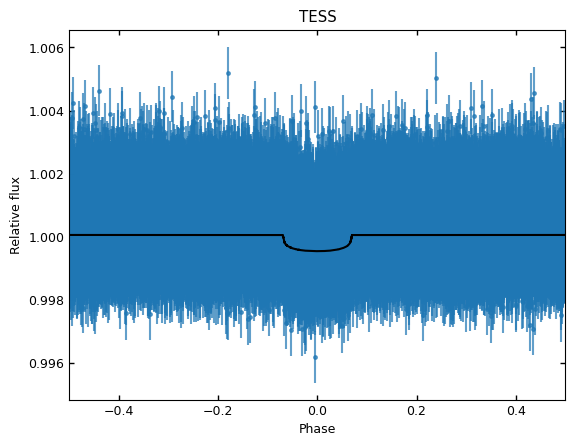

In [7]:
phase_tess, flux_tess, flux_err_tess, model_tess, m_tess, gp_model_tess = plot_with_gp("TESS","TESS","TESS_det.csv",P,t0)

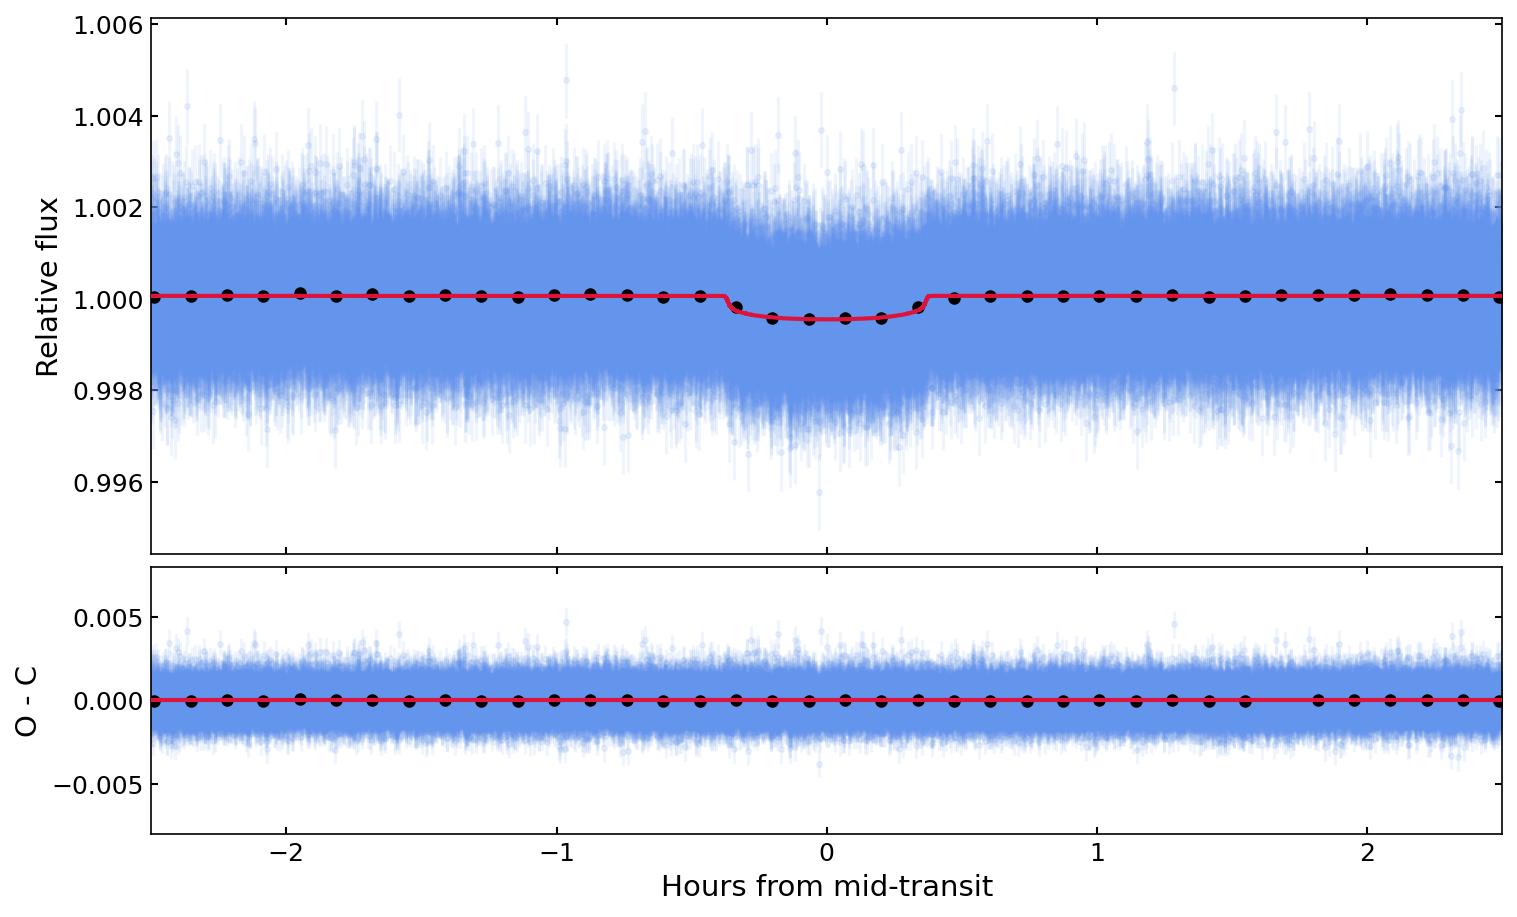

In [8]:
def bin_lc(phase, f, num_bins=40):
    # Shift phase from [-0.5, 0.5] to [0, 1] for binning
    phase = np.mod(phase + 1, 1)

    # Define bin edges and centers
    bin_edges = np.linspace(0, 1, num_bins + 1)
    binned_phase = (bin_edges[:-1] + bin_edges[1:]) / 2
    binned_flux = np.full(num_bins, np.nan)  # Initialize with NaNs

    for i in range(num_bins):
        mask = (phase >= bin_edges[i]) & (phase < bin_edges[i + 1])
        if np.any(mask):
            binned_flux[i] = np.mean(f[mask])  # Mean flux in bin

    # Convert phase back to [-0.5, 0.5] for correct plotting
    binned_phase = binned_phase - (binned_phase > 0.5)

    return binned_phase, binned_flux

fig = plt.figure(figsize=(10,6),dpi=150,constrained_layout=True)

gs = fig.add_gridspec(3, 6)
ax1 = fig.add_subplot(gs[:2, :])
ax2 = fig.add_subplot(gs[2, :], sharex = ax1)

phase_bin, flux_bin = bin_lc(phase_tess, flux_tess)

ax1.errorbar(phase_tess*P*24.,flux_tess-gp_model_tess,flux_err_tess,fmt = '.', alpha=0.1,color="cornflowerblue")
idx = np.argsort(phase_tess)
ax1.plot(phase_tess[idx]*P*24.,model_tess[idx], color='crimson',zorder=10,lw=2)

ax1.plot((phase_bin)*P*24.,flux_bin,"o",color="k",zorder=5)

#ax1.set_ylim()
plt.setp(ax1.get_xticklabels(), visible=False)
ax1.set_ylabel('Relative flux',fontsize=14)

res = flux_tess-gp_model_tess-model_tess

phase_res_bin, res_bin = bin_lc(phase_tess, res)

ax2.errorbar(phase_tess*P*24.,res,flux_err_tess,fmt = '.', alpha=0.1,color="cornflowerblue")
ax2.axhline(0.0,lw=2,color="crimson",zorder=30)
ax2.plot((phase_bin)*P*24.,res_bin,"o",color="k",zorder=5)

ax2.set_xlim(-2.5,2.5)
ax2.set_ylim(-0.008,0.008)
#ax2.set_xticks([-2,-1,0,1,2,3])
ax2.set_xlabel(r'Hours from mid-transit',fontsize=14)
ax2.set_ylabel('O - C', fontsize = 14)

ax1.tick_params(labelsize=12)
ax2.tick_params(labelsize=12)

fig.set_facecolor('w')
#plt.tight_layout()
#fig.legend(loc='upper center', bbox_to_anchor=(0.55, 1.07),ncol=6, fancybox=True, fontsize=9)
#plt.savefig("TOI-2431_PHOT.png", bbox_inches="tight", dpi=600)
plt.show()
plt.close()